In [2]:
import json
from matplotlib.font_manager import json_dump
import numpy as np
import pandas as pd
from pandas import json_normalize
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pylab as plt
import os
  

sf_data = []
vicon_data = []
#dataset_name = "test_data"
#path_sf = "D:/Arbeit/6GEM/Program_Development/6GEM_Dataset/sensorfloor_measurement/24102022"
#file_name_sf = "sensor_floor_data_24102022_" + dataset_name + ".txt"
file_name_sf = "current_data/test_data_1608_4_transmitters.txt"
#os.chdir(path_sf)

#for line in open("../Dataset_sensor_floor/sensorfloor_measurement/16092022/sensor_floor_data_16092022_" + dataset_name + ".txt", "r"):
#for line in open("../../../media/irfan-flw/OS/Arbeit/6GEM/Program_Development/6GEM_Dataset/sensorfloor_measurement/16092022/sensor_floor_data_16092022_" + dataset_name + ".txt", "r"):
for line in open(file_name_sf, "r"):
    sf_data.append(json.loads(line))

df_sf = pd.DataFrame(sf_data)
df_sf

,timestamp,strip_id,node_id,data,column_num
0,1.692200e+09,b8:27:eb:e7:6f:dc,14,"[{'a': [0.01904296875, 0.133056640625, 1.05297...",5
1,1.692200e+09,b8:27:eb:6d:0e:53,12,"[{'a': [0.05419921875, 0.111572265625, 1.08691...",8
2,1.692200e+09,b8:27:eb:09:3d:77,14,"[{'a': [0.0517578125, 0.08544921875, 1.0070800...",17
3,1.692200e+09,b8:27:eb:88:8d:56,14,"[{'a': [0.00634765625, 0.1328125, 1.0266113281...",21
4,1.692200e+09,b8:27:eb:41:99:a0,3,"[{'a': [0.067138671875, 0.1416015625, 0.987304...",1
...,...,...,...,...,...
1958,1.692200e+09,b8:27:eb:00:be:93,15,"[{'a': [0.11669921875, 0.1953125, 1.0524902343...",22
1959,1.692200e+09,b8:27:eb:be:dc:32,12,"[{'a': [0.056396484375, 0.1845703125, 0.980957...",10
1960,1.692200e+09,b8:27:eb:b7:a3:b7,7,"[{'a': [0.0458984375, 0.135498046875, 1.063720...",9
1961,1.692200e+09,b8:27:eb:05:d8:4d,4,"[{'a': [0.009033203125, 0.132568359375, 0.9689...",18


## Build the dataframe of sensor floors ##

***Timestamp Interpolation***

In [3]:
#test timestamp interpolation
#t_batch_i_now = np.zeros((23,15))
t_batch_i_old = np.zeros((23,15))
df_sf_buf = df_sf.copy()


#df_sf_buf = df_sf_buf.reindex(df_sf_buf.columns.tolist() + ['ax','ay','az','gx','gy','gz','mx','my','mz','rssi'], axis=1) 
out = []
for index, row in df_sf_buf.T.items():
    index_strip_id = int(df_sf_buf['column_num'][index])
    index_node_id = int(df_sf_buf['node_id'][index])
    #print('t_batch: ', df_sf_buf['timestamp'][index])
    #t_batch_i_now[index_strip_id][index_node_id] = df_sf_buf['timestamp'][index]
    #print(t_batch_i_old[index_strip_id-1][index_node_id-1])
    delta_t = 0
    timestamp_i = 0

    for i in range(len(df_sf_buf['data'][index])):

        #check timestamp
        if t_batch_i_old[index_strip_id-1][index_node_id-1] < df_sf_buf['timestamp'][index] and t_batch_i_old[index_strip_id-1][index_node_id-1] > 0:
            delta_t = (df_sf_buf['timestamp'][index] - t_batch_i_old[index_strip_id-1][index_node_id-1])/len(df_sf_buf['data'][index])
            
            t_i = t_batch_i_old[index_strip_id-1][index_node_id-1] + ((1+i)*delta_t)
            if df_sf_buf['data'][index][i]['r'][0] < 0:
                #print('iter > 0: ', delta_t)
                out.append({'strip_id':df_sf_buf['column_num'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':df_sf_buf['data'][index][i]['r'][0],'timestamp':t_i})
            else:
                out.append({'strip_id':df_sf_buf['column_num'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':np.nan,'timestamp':t_i})
                #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
            # t_batch_i_old[index_strip_id-1][index_node_id-1] = df_sf_buf['timestamp'][index]

        elif t_batch_i_old[index_strip_id-1][index_node_id-1] == 0:
            delta_t = 4/19
            #print('iter 0: ', delta_t)
            t_i = (df_sf_buf['timestamp'][index]-4) + ((1+i)*delta_t)
            if df_sf_buf['data'][index][i]['r'][0] < 0:
                #print(t_i)
                out.append({'strip_id':df_sf_buf['column_num'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':df_sf_buf['data'][index][i]['r'][0],'timestamp':t_i})
            else:
                out.append({'strip_id':df_sf_buf['column_num'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':np.nan,'timestamp':t_i})
            #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
            t_first = (df_sf_buf['timestamp'][index]) - 4           
            t_batch_i_old[index_strip_id-1][index_node_id-1] = t_first
            #print(t_batch_i_old[index_strip_id-1][index_node_id-1])
    
    
    t_batch_i_old[index_strip_id-1][index_node_id-1] = df_sf_buf['timestamp'][index]    
    #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
        

df_sf_final = pd.DataFrame(out)
del(out)
df_sf_final = df_sf_final.sort_values(['timestamp'])
df_sf_final = df_sf_final.reset_index(drop=True)
df_sf_final

,strip_id,node_id,ax,ay,az,gx,gy,gz,mx,my,mz,r,timestamp
0,5,14,0.019043,0.133057,1.052979,1.328244,1.122137,0.740458,18.00,-10.20,52.50,-66.0,1.692200e+09
1,8,12,0.054199,0.111572,1.086914,-0.389313,1.717557,1.328244,-8.55,16.80,6.00,-70.0,1.692200e+09
2,17,14,0.051758,0.085449,1.007080,-1.282443,1.045802,0.496183,146.85,-69.00,6.30,-71.0,1.692200e+09
3,21,14,0.006348,0.132812,1.026611,-1.885496,1.091603,1.648855,14.70,-22.80,72.75,-70.0,1.692200e+09
4,1,3,0.067139,0.141602,0.987305,-0.908397,0.694656,-0.175573,-58.35,19.95,257.55,-73.0,1.692200e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36697,22,15,0.113281,0.196533,1.046387,-0.038168,1.595420,0.503817,37.95,22.05,-26.40,-77.0,1.692200e+09
36698,10,12,0.055908,0.182373,0.984863,-0.832061,1.358779,0.809160,45.00,255.00,10.50,-65.0,1.692200e+09
36699,9,7,0.049072,0.135010,1.061768,-2.160305,0.358779,2.580153,80.40,-91.80,23.10,-74.0,1.692200e+09
36700,18,4,0.007812,0.127930,0.977783,0.511450,0.374046,0.877863,27.75,40.95,-114.15,-60.0,1.692200e+09


**Build Dataset of VICON Coordinates**

In [5]:
#DATASET OF VICON COORDINATES
#for line in open("../Dataset_sensor_floor/vicon_measurement/16092022/vicon_data_16092022_" + dataset_name + ".txt", "r"):
# path_vicon = "D:/Arbeit/6GEM/Program_Development/6GEM_Dataset/vicon_measurement/24102022"
# file_name_vicon = "vicon_data_24102022_" + dataset_name + ".txt"

# os.chdir(path_vicon)
file_name_vicon = "current_data/vicon_data_test_1608_4_transmitters.txt"

for line in open(file_name_vicon, "r"):
    vicon_data.append(json.loads(line))

df_vicon = pd.DataFrame(vicon_data)
#df_vicon['time'] = pd.to_datetime(df_vicon['time'],unit='s')
df_vicon.shape
df_vicon_buf = df_vicon.copy()
df_vicon_buf = df_vicon_buf.reindex(df_vicon_buf.columns.tolist() + ['X','Y'], axis=1) 

for index, row in df_vicon_buf.T.items():
    for i in range(len(df_vicon_buf['translation'][index])):
        #print((test_df['data'][index][i]['r']))
        df_vicon_buf.loc[index,'X'] = df_vicon_buf['translation'][index][0]
        df_vicon_buf.loc[index,'Y'] = df_vicon_buf['translation'][index][1]

df_vicon_buf = df_vicon_buf.drop(columns=['object','translation','rotation'])

***Filter and Resample Vicon Data***

In [6]:
df_vicon_resample = df_vicon_buf.copy()
df_vicon_resample['time_resample'] = pd.to_datetime(df_vicon_resample['time'],unit='s')
#df_vicon_resample['time'] = df_vicon_resample['time'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f'))
df_vicon_resample = df_vicon_resample.set_index('time_resample')
df_vicon_final = df_vicon_resample.resample('40ms').ffill()
df_vicon_final = df_vicon_final.dropna()
df_vicon_final = df_vicon_final.sort_values(['time'])
df_vicon_final = df_vicon_final.reset_index(drop=True)
df_vicon_final

,time,X,Y
0,1.692200e+09,0.424041,0.067686
1,1.692200e+09,0.424113,0.067744
2,1.692200e+09,0.424117,0.067739
3,1.692200e+09,0.424154,0.067832
4,1.692200e+09,0.424142,0.067744
...,...,...,...
598,1.692200e+09,1.724472,1.523026
599,1.692200e+09,1.724251,1.522893
600,1.692200e+09,1.724461,1.523095
601,1.692200e+09,1.724387,1.523128


**CREATE ARRAY OF RSSI & VICON COORDINATES**

In [7]:
from turtle import width
import matplotlib.animation as animation
%matplotlib ipympl
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#CREATE DATASET FOR SENSOR FLOOR ARRAY
x_sf = df_sf_final['strip_id'].to_numpy()
y_sf = df_sf_final['node_id'].to_numpy()
z_sf = df_sf_final['r'].to_numpy()
t_sf = df_sf_final['timestamp'].to_numpy()
dataSet_sf = np.array([x_sf, y_sf, z_sf, t_sf])
numDataPoints_sf = len(t_sf)
num_of_nodes = 15
num_of_strips = 23

delta_t_sf = round((t_sf.max()-t_sf.min())/numDataPoints_sf, 6)

print('dataset sf: ', dataSet_sf.shape)

#-------------------------------------------------------------------------------------------------------------------#

#CREATE DATASET FOR VICON COORDINATES
t_vc = df_vicon_final['time'].to_numpy()
x_vc = df_vicon_final['X'].to_numpy()
y_vc = df_vicon_final['Y'].to_numpy()
dataSet_vc = np.array([x_vc, y_vc, t_vc])
numDataPoints_vc = len(t_vc)

delta_t_vc = round((t_vc.max()-t_vc.min())/numDataPoints_vc, 6)

print("dataset vc:", dataSet_vc.shape)

#-------------------------------------------------------------------------------------------------------------------#
#Check the index of closest timestamp to Vicon Dataset

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #print(np.abs(array - value), len(np.abs(array - value)))
    return idx


#closest_index_vicon = []
closest_index_sf = []


for i in range(numDataPoints_vc):
    pos = t_vc[i]
    #index_vicon = find_nearest(dataSet_vc[2], pos)
    index_sf = find_nearest(dataSet_sf[3], pos)

    #closest_index_vicon.append(index_vicon)
    closest_index_sf.append(index_sf)

print(len(closest_index_sf))

dataset sf:  (4, 36702)
dataset vc: (3, 603)
603


In [6]:
# import numpy as np
# import pandas as pd

# # Assuming df_sf_final and df_vicon_final are your pandas DataFrames

# # CREATE DATASET FOR SENSOR FLOOR ARRAY
# x_sf = df_sf_final['strip_id'].to_numpy()
# y_sf = df_sf_final['node_id'].to_numpy()
# z_sf = df_sf_final['r'].to_numpy()
# t_sf = df_sf_final['timestamp'].to_numpy()
# dataSet_sf = np.array([x_sf, y_sf, z_sf, t_sf])
# numDataPoints_sf = len(t_sf)

# delta_t_sf = round((t_sf.max() - t_sf.min()) / numDataPoints_sf, 6)

# print('dataset sf: ', dataSet_sf.shape)

# # CREATE DATASET FOR VICON COORDINATES
# t_vc = df_vicon_final['time'].to_numpy()
# x_vc = df_vicon_final['X'].to_numpy()
# y_vc = df_vicon_final['Y'].to_numpy()
# dataSet_vc = np.array([x_vc, y_vc, t_vc])
# numDataPoints_vc = len(t_vc)

# delta_t_vc = round((t_vc.max() - t_vc.min()) / numDataPoints_vc, 6)

# print("dataset vc:", dataSet_vc.shape)

# # Create a DataFrame for the sensor floor data
# df_sf = pd.DataFrame(dataSet_sf.T, columns=['strip_id', 'node_id', 'r', 'timestamp'])

# # Convert timestamp columns to the same data type
# df_sf['timestamp'] = df_sf['timestamp'].astype(float)

# # Create a DataFrame for the Vicon coordinates data
# df_vc = pd.DataFrame(dataSet_vc.T, columns=['X', 'Y', 'time'])

# # Convert time columns to the same data type
# df_vc['time'] = df_vc['time'].astype(float)

# # Merge the two DataFrames based on closest timestamps
# merged_df = pd.merge_asof(df_vc, df_sf, left_on='time', right_on='timestamp')

# # Calculate the closest index for sensor floor data
# closest_index_sf = merged_df.index

# print(len(closest_index_sf))

**CREATE FRAME FOR MERGED DATASET**

In [7]:
# import numpy as np
# import pandas as pd
# from tqdm import tqdm_notebook as tqdm
# import os

# path = "D:/Arbeit/6GEM/Program_Development/Sensorfloor/SensorFloor_Evaluation_Tool"
# os.chdir(path)

# # ... (Assuming you have loaded your data and defined necessary variables)
# KEYS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'r', 'timestamp']
# Vicon_Coords = pd.read_csv("vicon_node_positions.csv")
# # Convert Vicon_Coords to integer type
# df_data = Vicon_Coords[['strip_id', 'node_id']].astype('int32')
# # df_data = Vicon_Coords[['strip_id','node_id']]
# # df_data = df_data.astype('int32')

# X = np.zeros((len(closest_index_sf), 23, 15, 11))
# t = np.zeros((len(closest_index_sf), 1))
# frames = []
# dataSet_vc_final = []
# cnt = 0

# for index, row in tqdm(df_sf_final.iterrows(), total=len(df_sf_final)):
#     df_i = row

#     # Create a copy of X_i for manipulation
#     X_i = np.zeros((23, 15, 11))

#     for i, key in enumerate(KEYS):
#         strip_id = df_data['strip_id']
#         node_id = df_data['node_id']
#         X_i[strip_id - 1, node_id - 1, i] = df_i[key]

#     #df_data[['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'r', 'timestamp']] = X_i.reshape(345, 11)
#     df_data.loc[:, ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'r', 'timestamp']] = X_i.reshape(345, 11)

#     frame_bool = df_data.empty

#     if index in closest_index_sf and not frame_bool:
#         index_assoc = closest_index_sf[index]
#         frames.append(df_data.to_dict(orient='records'))
#         X[len(dataSet_vc_final)] = X_i
#         t[len(dataSet_vc_final)] = df_i['timestamp']
#         dataSet_vc_final.append(dataSet_vc[:, index_assoc])
#         cnt += 1

# # Convert the list of dicts to a DataFrame
# df_frames = pd.DataFrame(frames)

# # Convert the list of Vicon data to a NumPy array
# dataSet_vc_final = np.array(dataSet_vc_final)

# print(X.shape, t.shape, df_frames.shape, dataSet_vc_final.shape)


In [8]:
#CREATE ARRAY FOR DATA SENSORS
#from asyncio.windows_events import NULL
from tqdm import tqdm_notebook as tqdm

# path = "D:/Arbeit/6GEM/Program_Development/Sensorfloor/SensorFloor_Evaluation_Tool"
# os.chdir(path)

KEYS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'r', 'timestamp']
Vicon_Coords = pd.read_csv("vicon_node_positions.csv")
df_data = Vicon_Coords[['strip_id','node_id']]
df_data = df_data.astype('int32')

X = np.zeros([len(closest_index_sf), 23, 15, 11])
t = np.zeros([len(closest_index_sf), 1])
frames = []
dataSet_vc_X = []
dataSet_vc_Y = []
dataSet_vc_t = []
cnt = 0
X_i = np.zeros([23, 15, 11])

for index, row in tqdm(df_sf_final.T.items(), total=len(df_sf_final)):

    df_i = row

    for i, key in enumerate(KEYS):
        X_i[int(df_i.strip_id) - 1, int(df_i.node_id) - 1, i] = df_i[key]
    
    X_df = X_i.reshape([345,11])
    df_X = pd.DataFrame(X_df, columns=KEYS)
    df_data[['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'r', 'timestamp']] = df_X
    frame_i = df_data.to_json(orient='columns')
    
    t_i = df_i.timestamp

    # X[index] = X_i
    # t[index] = t_i
    #frames.insert(index, frame_i)
    frame_bool = df_data.empty
    #print(frame_bool)

    if index in closest_index_sf and not frame_bool:
       
        #print(df_data)
        index_assoc = closest_index_sf.index(index)
        #print(cnt, index, index_assoc)
        frames.append(frame_i)
        #frames[cnt] = frame_i
        X[cnt] = X_i
        t[cnt] = t_i
        dataSet_vc_X.append(dataSet_vc[0,index_assoc])
        dataSet_vc_Y.append(dataSet_vc[1,index_assoc])
        dataSet_vc_t.append(dataSet_vc[2,index_assoc])
        #dataSet_vc_final.append(dataSet_vc[:,index_assoc])
        #print(dataSet_vc[0,index_assoc],dataSet_vc[1,index_assoc],dataSet_vc[2,index_assoc])

        # frames[index_assoc] = frame_i
        # X[index_assoc] = X_i
        # t[index_assoc] = t_i
        cnt += 1
    #print(index,'/',len(df_sf_final))

dataSet_vc_final = np.array([dataSet_vc_X, dataSet_vc_Y, dataSet_vc_t])
print(X.shape, t.shape, len(frames), dataSet_vc_final.shape)

/tmp/ipykernel_29570/4036406857.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df_sf_final.T.items(), total=len(df_sf_final)):


  0%|          | 0/36702 [00:00<?, ?it/s]

(603, 23, 15, 11) (603, 1) 581 (3, 581)


**Check index of timestamp threshold**

In [9]:
sensor_data_final = X[:cnt-1]
t_data_final = t[:cnt-1]
frames_final = frames[:cnt-1]

#dataSet_vc_final = dataSet_vc[:,:]
dataSet_vc_final = dataSet_vc_final[:,:-1]
dataSet_vc_final = np.transpose(dataSet_vc_final)

#print(index_low_X, t[index_low_X] , index_low_vc, dataSet_vc[2][index_low_vc])
print(sensor_data_final.shape, t_data_final.shape, len(frames_final), dataSet_vc_final.shape)

(580, 23, 15, 11) (580, 1) 580 (580, 3)


**MERGE RSSI HEATMAP & VICON COORDINATES WITH SLIDER**

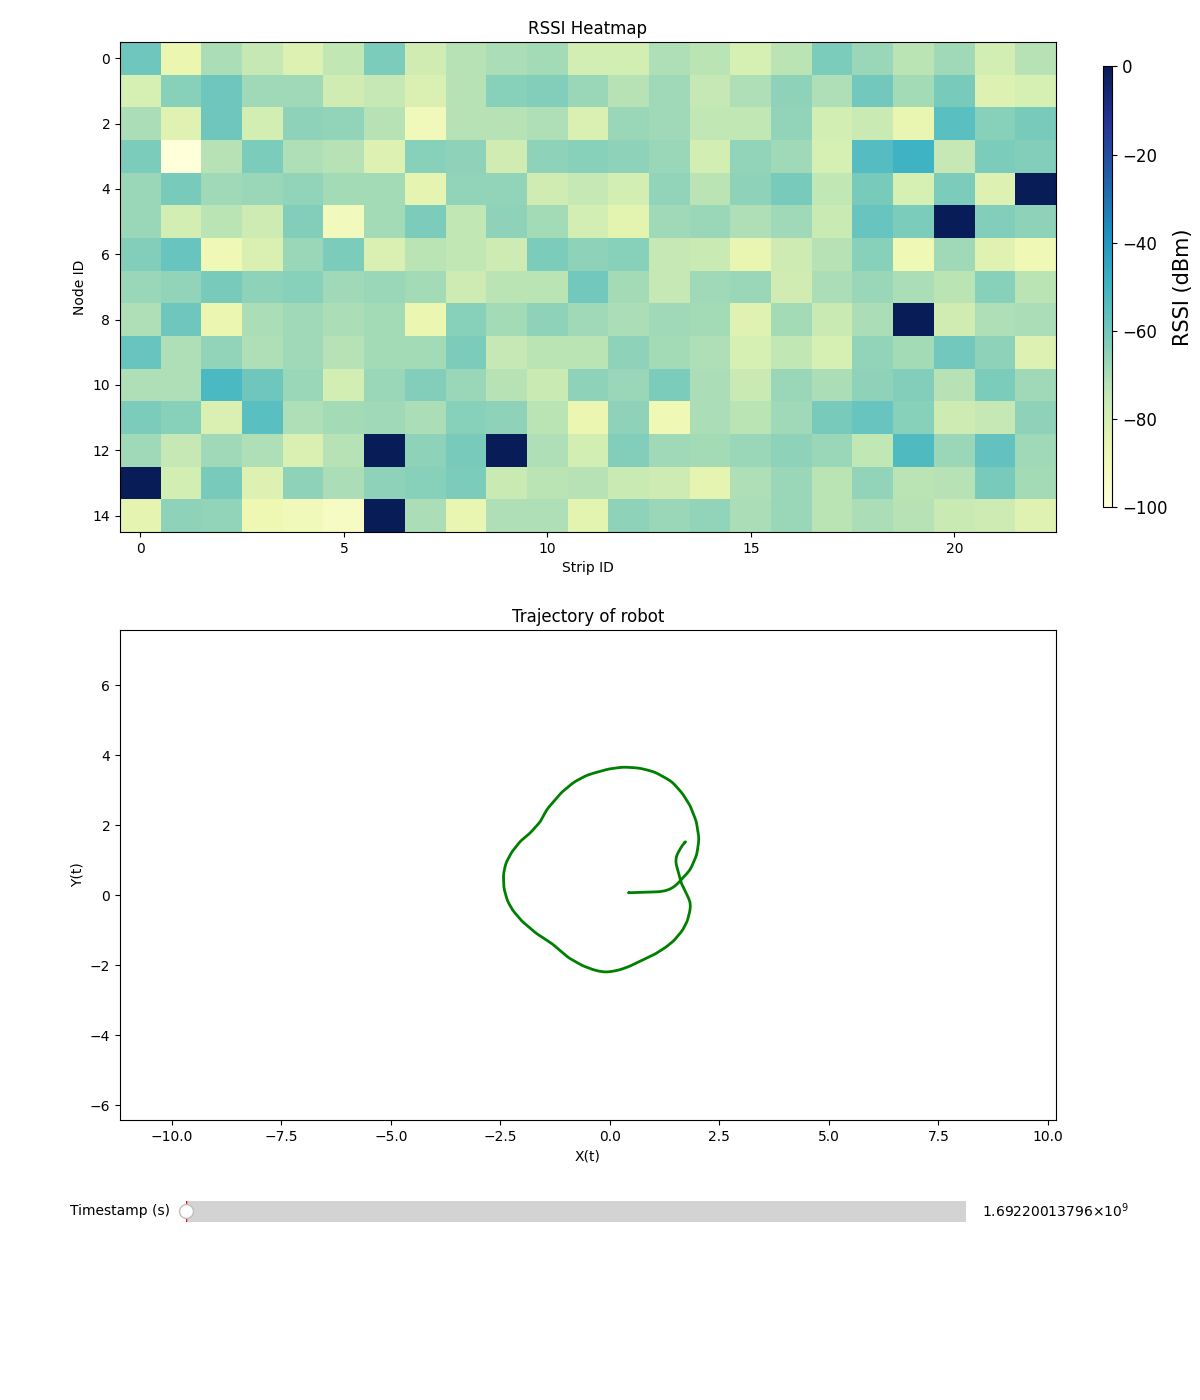

In [10]:
#MERGE RSSI HEATMAP & VICON COORDINATES WITH SLIDER
from turtle import width
import matplotlib.animation as animation
%matplotlib ipympl
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

rssi_data = sensor_data_final[:,:,:,9]
rssi_data_transpose = np.transpose(rssi_data, [0,2,1])

numdataPoints = len(dataSet_vc_final)

# GET SOME MATPLOTLIB OBJECTS
#fig, (ax1, ax2) = plt.subplots(figsize=(10,12), nrows=2)
fig = plt.figure(figsize=(12,14))
plt.subplots_adjust(bottom=0.25)

# AXES PROPERTIES RSSI HEATMAP
ax1 = fig.add_subplot(211) #(row, column, pos)
#ax1.set_autoscale_on
ax1.set_xlabel('Strip ID')
ax1.set_ylabel('Node ID')
ax1.set_title('RSSI Heatmap')

# # AXES PROPERTIES VICON COORDINATES
ax2 = fig.add_subplot(212)
ax2.set_xlim(-11.185, 10.185)
ax2.set_ylim(-6.425, 7.575)
ax2.set_xlabel('X(t)')
ax2.set_ylabel('Y(t)')
ax2.set_title('Trajectory of robot')


# Defining the Slider button
# xposition, yposition, width and height
# ax_slide_sf = plt.axes([0.155, 0.02, 0.65, 0.03])
# ax_slide_vc = plt.axes([0.155, 0.07, 0.65, 0.03])
ax_slide_merge = plt.axes([0.155, 0.12, 0.65, 0.03])

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #print(np.abs(array - value), len(np.abs(array - value)))
    return idx


#DISPLAY INITIAL IMAGE
im_h = ax1.imshow(rssi_data_transpose[numdataPoints-1], cmap="YlGnBu", aspect='auto')
axins = inset_axes(ax1,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 1.25, 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
cbar = plt.colorbar(im_h, cax=axins, ax=ax1)
cbar.set_label(label='RSSI (dBm)', size=15)
cbar.ax.tick_params(labelsize=12)


#cbar.ax.set_axes_locator
# #cbar.set_ticks()

line = ax2.plot(dataSet_vc_final[:,0], dataSet_vc_final[:,1], lw=2, c='g')[0] # For line plot

# Properties of the slider

#normal data
timestamp_merge = Slider(ax_slide_merge, 'Timestamp (s)',
                  t_vc.min(), t_vc.max(), valinit=t_vc.min(), valstep=delta_t_vc)

 

def update_all(val):
    pos = timestamp_merge.val
    #print(pos)
    index = find_nearest(dataSet_vc_final[:,2], pos)
    line.set_xdata(dataSet_vc_final[:index,0])
    line.set_ydata(dataSet_vc_final[:index,1])

    #index2 = find_nearest(dataSet_sf[3], dataSet_vc_final[2][index])
    im_h.set_data(rssi_data_transpose[index])

    #redrawing the figure
    fig.canvas.draw() 

# Calling the function "update" when the value of the slider is changed

timestamp_merge.on_changed(update_all)

#fig.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.88, top=0.97, hspace=0.2)
#plt.subplots_adjust(left=0.155, bottom=0.2, right=0.91, top=0.97, hspace=0.2)
#plt.subplot_tool()
plt.show()

In [ ]:
home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/output/plot_img'
os.chdir(home_path)
plt.savefig(dataset_name + '_test_run_2810.png', dpi=300)

In [ ]:
#MERGE DATASET

#dataSet_vc_final = np.transpose(dataSet_vc_final)
frame_number = np.empty(dataSet_vc_final.shape[0], dtype=object)
frame_data = np.empty(dataSet_vc_final.shape[0], dtype=object)
frame_count = 0
for row in range(dataSet_vc_final.shape[0]):
    time_vc = dataSet_vc_final[row][2]
    #time_vc = dataSet_vc[2][row]
    #index_vc = closest_timestamp(dataSet_vc[2], time_vc)
    #index_sf = closest_timestamp(t_data_final, time_vc)

    frame_number[row] = str(frame_count)
    frame_data[row] = frames_final[row]
    frame_count += 1

**GENERATES THE DATASET AS .CSV FILE**

In [ ]:
array_frame_vc = dataSet_vc_final.astype(object)

dataSet_final = np.array([frame_number, array_frame_vc[:,0], array_frame_vc[:,1], frame_data])
dataSet_final = np.transpose(dataSet_final)
#dataSet_final.shape
frame_sf = pd.DataFrame(dataSet_final, columns=['frame_number','vicon_x','vicon_y','data'])

path_dataset = '/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/24102022/'

os.chdir(path_dataset)

frame_sf.to_csv(r'/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/24102022/' +  dataset_name + '.csv', index=False)

#data_dir = '../Dataset_sensor_floor/Dataset_Final/30092022/'
#csv_name = data_dir + 'dataset_3009022_' + dataset_name + '.csv'
# csv_name = path_dataset + dataset_name + '.csv'
# frame_sf.to_csv(csv_name, index=False)
#dataSet_final

**GENERATES TEST DATASET AS .CSV FILE**

In [ ]:
array_frame_vc = dataSet_vc_final.astype(object)

test_dataset = np.array([frame_number, frame_data])
test_dataset = np.transpose(test_dataset)

ground_truth = np.array([frame_number, array_frame_vc[:,2], array_frame_vc[:,0], array_frame_vc[:,1]])
ground_truth = np.transpose(ground_truth)

frame_test = pd.DataFrame(test_dataset, columns=['frame_number','data'])
frame_ground_truth = pd.DataFrame(ground_truth, columns=['frame_number','time','vicon_x','vicon_y'])

path_dataset = '/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/24102022/'

os.chdir(path_dataset)

frame_test.to_csv(r'/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/28102022/' +  dataset_name + '.csv', index=False)
frame_ground_truth.to_csv(r'/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/28102022/' +  dataset_name + '_gt.csv', index=False)

In [ ]:
array_frame_vc[:,2]

**Store the data to pickle**

In [ ]:
import pickle

data_pickle_file = 'pickle/' + dataset_name + '_24102022.pkl'

# write data
pickle_data = [sensor_data_final, dataSet_vc_final, t_data_final]
with open(data_pickle_file, 'wb') as handle:
    pickle.dump(pickle_data, handle, protocol=3)
print('Successfully stored!')